In [9]:
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interactive, interact
from matplotlib import animation, rc
import ipywidgets as widgets
%matplotlib widget
from scipy import fftpack as fft
from scipy import signal as sig


In [2]:
#Import Data
raw0 = np.fromfile(open("open_press"), dtype=np.complex64)

#The FMCOMMS3 uses an automatic gain control. Haven't figured out how to config manual gain control correctly so I need to remove pre-gain correction.

#Constants
fs = 2083998 # Samples/seconds
#Note: set gain to ~45dB and configure gr-iio to manual gain mode in GRC TODO: nake this work.

#raw0 with respect to time
T = np.linspace(0.0, raw0.size/fs, raw0.size)

In [ ]:
#Lets view raw signal and its FT
%matplotlib widget
plt.figure()
plt.plot(T, raw0.real, T, raw0.imag)
plt.show()

yf = fft.fft(raw0)
yf = fft.fftshift(yf)
xf = fft.fftfreq(raw0.size, 1/fs)
xf = fft.fftshift(xf)

plt.figure()
plt.plot(xf, yf)
plt.show()


In [5]:
#TODO: To optimize integrate this into find packets method
#isolate noisy start/where gain is not set correctly
sos = sig.butter(15, 100, 'lp', fs=fs, output='sos')
rawf = sig.sosfilt(sos, raw0)

gain_set =abs(rawf)>.005  

gain_set_loc = np.argmax(gain_set)
print(raw0.size, gain_set_loc)
raw = raw0[gain_set_loc:]

#Show successful isolation. New dataset is in orange
plt.figure()
plt.plot(T, raw0.real, T[gain_set_loc:], raw.real)
plt.show()

raw0 = raw
T = np.linspace(0.0, raw0.size/fs, raw0.size)

20807680 5872421


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
#Now that we can hypothosize that the remote sends a same/similar message the longer the button is pressed, we can 
#isolatethe message based on the first occurence 
#Maybe optimal method is to use derivative like what is used to isolate bits

def isolatePacket(raw_data):
    SMPL_BUFF = 2000 # buffer to 
    PCKT_SIZE_EST = 50000
    tx =abs(raw_data)>.05  
    msg_loc = np.where(tx == True)[0] #locatoins where value non-zero
    print(msg_loc[0:30])
    start_tx = msg_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
    
    #find end of packet
    diff_msg_loc = np.roll(msg_loc, 1)
    diff_msg_loc[0] = msg_loc[0]
    temp = np.where((msg_loc - diff_msg_loc) > PCKT_SIZE_EST)[0]
    end_tx = msg_loc[temp[0]] - PCKT_SIZE_EST + SMPL_BUFF
  
    return [start_tx, end_tx]


pkt_size = isolatePacket(raw0)
print(pkt_size)
raw_pkt = raw0[pkt_size[0]:pkt_size[1]]
#x_raw_pkt = T[pkt_size[0]:pkt_size[1]] #For plotting in time
x_raw_pkt = range(raw_pkt.real.size)

%matplotlib widget
plt.figure(2)
plt.plot(x_raw_pkt, raw_pkt.real, x_raw_pkt, raw_pkt.imag)
plt.show()

[5512611 5512612 5512613 5512614 5512615 5512616 5512617 5512618 5512619
 5512620 5512621 5512622 5512623 5512624 5512625 5512626 5512627 5512628
 5512629 5512630 5512631 5512632 5512633 5512634 5512635 5512636 5512637
 5512638 5512639 5512640]
[5510611, 5672387]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
#Isolate bits
#maybe another/smarter way to do this is to use the derivative
#Based on graphical observation of the graph above, I found 4 bit lengths in # of samples. I will average to get an
#    estimated bit length

bLeng_raw = [9.415e5-4.205e5, 9.411e5-9.404e5, 9.431e5-9.425e5, 9.441e5-9.435e5]
BLENG_EST = int (np.sum(bLeng_raw) / len(bLeng_raw))
BLENG_EST = 400

ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
SMPL_BUFF = 100 # buffer to add at the end of the bit for optimal viewing

#Method 1 using zero threshold
tx =abs(raw_pkt)>ZERO_TRESH 
bit_loc = np.where(tx == True)[0] #locations where value non-zero
start_tx = bit_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
end_tx = start_tx + BLENG_EST + 2*SMPL_BUFF

print(start_tx, end_tx)
raw_bit = raw_pkt[start_tx:end_tx]
x_raw_bit = x_raw_pkt[start_tx:end_tx]


%matplotlib notebook
plt.figure(4)
plt.plot(x_raw_bit, raw_bit.real, x_raw_bit, raw_bit.imag)
plt.show()

plt.figure(5)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()

   

1900 2500


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
#I want to see what this looks like in freq domain
N = 630000000
fft_pkt = fft.fft(raw_pkt)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

%matplotlib notebook
plt.figure(9)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [11]:
def isolateBitThresh(pkt):
    BLENG_EST = 500     #Bit length estimate in samples
    ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
    SMPL_BUFF = 0 # buffer to add at the end of the bit for optimal viewing

    #pkt = pkt[start:]    #TODO needs to be made more efficient
    tx =abs(pkt)>ZERO_TRESH 
    bit_loc = np.where(tx == True)[0] #locations where value non-zero
    start_tx = bit_loc - SMPL_BUFF #I know this is dangerous but I'm a badass
    end_tx = bit_loc + BLENG_EST + SMPL_BUFF
    bit_bounds = [start_tx, end_tx]
    return (start_tx, end_tx)


In [12]:
#Get symbol bounds
bounds = isolateBitThresh(raw_pkt)

#Get Symbols
symb = np.empty(bounds[0].size, dtype=complex)
for i in range(bounds[0].size):
    #integrate and dump
    #print(raw_pkt[bounds[0][i]:bounds[1][i]])
    temp = raw_pkt[bounds[0][i]:bounds[1][i]]
    symb[i] = np.sum(temp)
    symb[i] = symb[i] / abs(symb[i])

print(np.sum(raw_pkt[bounds[0][i]:bounds[1][i]]))
#By examining bounds, it is apparent that the function isolateBitThreshold doesn't do a good job identifying
#the bit start locations.
%matplotlib notebook
plt.figure(6)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
for i in range(9):
    print("Angle: ", np.angle(symb[i], deg=True), "Raw: ", symb[i])
    plt.scatter(symb[i].real, symb[i].imag)
plt.show()

plt.figure(7)
const = 10
for i in range(9):
    plt_num = 9*100 + 10 + i+1
    plt.subplot(plt_num)
    symbs = raw_pkt[bounds[0][i+const]:bounds[1][i+const]]
    print(symbs.size)
    plt.plot(range(symbs.size), symbs.real, range(symbs.size), symbs.imag)

(1.3530273+2.131836j)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Angle:  -76.7777876370555 Raw:  (0.22872828890821875-0.9734903029065664j)
Angle:  -75.96286066494409 Raw:  (0.2425507939909302-0.9701387077806809j)
Angle:  -74.55423187305983 Raw:  (0.26632615643537705-0.9638829692438594j)
Angle:  -73.1383920355221 Raw:  (0.290060998769174-0.9570081593137172j)
Angle:  -71.71298697643682 Raw:  (0.313777245903844-0.9494966245084806j)
Angle:  -70.34150425003696 Raw:  (0.33641318213040367-0.9417144848035925j)
Angle:  -69.01878904867058 Raw:  (0.35806178054036913-0.9336978961721295j)
Angle:  -67.67545369918456 Raw:  (0.3798524972765281-0.9250470692417685j)
Angle:  -66.87526805846333 Raw:  (0.3927341244941696-0.9196520578228475j)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

500
500
500
500
500
500
500
500
500


In [21]:
#Using a loop method to do integrate and dump based on the bit sizes
def isolateBitThreshLoop(pkt):
    BLENG_EST = 500     #Bit length estimate in samples
    ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
    SMPL_BUFF = 6 # buffer to add at the end of the bit for optimal viewing
    
    tx =abs(pkt)>ZERO_TRESH
    symbs = np.empty([int (tx.size/BLENG_EST), BLENG_EST], dtype=complex)
    #print(pkt[0:0+BLENG_EST])
    x = 0; #symbs array iterator
    i = 0
    while tx.size > i:
        if (True == tx[i]):
            #symbs[x] = np.sum(pkt[i:i+BLENG_EST])
            #symbs[x] = symbs[x] / abs(symbs[x])
            symbs[x] = pkt[i:i+BLENG_EST]
            
            x += 1
            i = i + BLENG_EST + SMPL_BUFF
            
        else:
            i += 1
    return symbs

symbs = isolateBitThreshLoop(raw_pkt)

plt.figure(7)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
for i in range(9):
    symb = np.sum(symbs[i])
    symb = symb / abs(symb)
    print("Angle: ", np.angle(symb, deg=True), "Raw: ", symb)
    plt.scatter(symb.real, symb.imag)
plt.show()

plt.figure(8)
const = 10
for i in range(9):
    plt_num = 9*100 + 10 + i+1
    plt.subplot(plt_num)
    plt.plot(range(symbs[i+const].size), symbs[i+const].real, range(symbs[i+const].size), symbs[i+const].imag)


print(np.where(symbs==False))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Angle:  -76.7777876370555 Raw:  (0.22872828890821875-0.9734903029065664j)
Angle:  49.08680747358258 Raw:  (0.6549148339057327+0.7557026930812317j)
Angle:  -56.716860110140864 Raw:  (0.548776845851012-0.8359688830679133j)
Angle:  -179.1611806920311 Raw:  (-0.9998928347899567-0.014639635777725505j)
Angle:  -26.50505239652247 Raw:  (0.8948950119735986-0.44627672754107733j)
Angle:  -154.14263022056338 Raw:  (-0.8998825269333619-0.4361323626148684j)
Angle:  86.14933075641306 Raw:  (0.06715627523897144+0.9977424691251885j)
Angle:  -142.60986356528676 Raw:  (-0.7945191695406035-0.6072390709041289j)
Angle:  116.12878051156885 Raw:  (-0.440390206775102+0.8978064745682017j)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([  1,  10,  10, ..., 322, 322, 322]), array([121, 383, 408, ..., 497, 498, 499]))


In [14]:
print(symbs)
def animate(frame):
    ln.set_data(symbs.real[frame], symbs.imag[frame])
    ln.title("Frame: ", frame)
    return ln

fig, ax = plt.subplots()
ln, = plt.scatter([],[])

ani = FuncAnimation(fig, animate, frames=range(symbs.size))

[[-0.11865234+9.76562500e-03j -0.65917969+5.71289062e-02j
  -0.61621094+1.00097656e-01j ...  0.49316406+3.92089844e-01j
   0.484375  +4.08691406e-01j  0.46386719+4.15527344e-01j]
 [ 0.54638672+3.87207031e-01j  0.15722656+1.43554688e-01j
  -0.02734375-2.73437500e-02j ...  0.00146484+3.90625000e-03j
   0.00390625+4.88281250e-04j  0.00244141+3.90625000e-03j]
 [-0.13378906-6.29882812e-02j -0.64453125-2.16796875e-01j
  -0.62744141-6.20117188e-02j ...  0.35302734+5.08789062e-01j
   0.36181641+4.99023438e-01j  0.35253906+5.20019531e-01j]
 ...
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.     

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: cannot unpack non-iterable PathCollection object

In [15]:
#Low pass filter using butterworth. Cutoff freq at 246 Hz. determined graphically

%matplotlib notebook

nyq = fs / 2
filter_freq = 246 / nyq
b, a = sig.butter(5, 246, 'low', fs=fs)
#taps = sig.firwin(5, 246, fs=fs)
filtered.real = sig.lfilter(b, a, raw_pkt.real)
filtered.imag = sig.lfilter(b, a, raw_pkt.imag)

fft_pkt = fft.fft(filtered.real)

#I Don't Understand why the FT plot looks like fig 9. However when looking at the results in the time domain it
#    looks like the filter works. Maybe a plotting issue???
plt.figure(9)
xf = fft.fftfreq(filtered.size, d=1/fs)
plt.plot(xf, filtered.real)

fft_pkt = fft.fft(raw_pkt.real)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

plt.figure(10)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)

plt.figure(11)
plt.plot(x_raw_pkt, filtered.real, x_raw_pkt, filtered.imag)
#plt.plot(x_raw_pkt, filtered.real)
plt.show()

NameError: name 'filtered' is not defined

In [19]:
#LPF fx. 5th order BW filter
#f_cutoff is the cutoff freq for the lpf
def lpf(data, fs, f_cutoff):
    sos = sig.butter(15, f_cutoff, 'lp', fs=fs, output='sos')
    filtered = sig.sosfilt(sos, raw0)

    return filtered


In [20]:
#Method 2 of bit isolations using derivative
#I have abandoned method 2 because it took too much time and method 1 works ok.
# added a LPF IOT to make results more consistent

DIFF_TRESH = .004

filt_pkt = lpf(raw_pkt, fs, 246)
diff_pkt = np.roll(filt_pkt, -1)    #diff_pkt is a copy of raw_pkt shifted 1 to the left

diff_pkt[-1] = filt_pkt[-1] 
diff = filt_pkt - diff_pkt


x_diff = range(diff.size)

%matplotlib notebook
plt.figure(6)
plt.plot(x_diff, diff.real)
plt.show()

tx =abs(diff.real)>=DIFF_TRESH 

bit_loc = np.where(tx == True)[0] #locations where value non-zero
print(bit_loc[0:20])
start_bit = bit_loc[0] 
end_bit = bit_loc[1] + 2

print(raw_pkt[1999:2010])
print(diff_pkt[1999:2010])
print(diff[1990:2010])
print(bit_loc[0])

plt.figure(9)
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].real, label='raw_pkt-real')
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].imag, label='raw_pkt-imag')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].imag, label='diff_pkt-imag')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].real, label='diff-real')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].imag, label='diff-imag')
plt.legend()
plt.show()

print(raw_pkt[2000])
print(diff_pkt[2000])
print(diff[2000])

bit_msg = filt_pkt[start_bit:end_bit]
x_diff = range(bit_msg.size)

plt.figure(7)
plt.plot(x_diff, bit_msg.real, x_diff, bit_msg.imag)
plt.show()

plt.figure(8)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

<IPython.core.display.Javascript object>


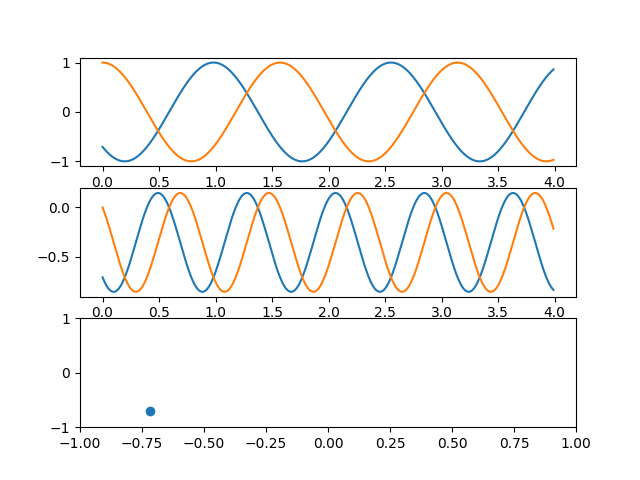

In [47]:
#Understanding Quadrature Demod
%matplotlib notebook

t = np.arange(0, 4, .01)
x = np.cos(4*t + 3*np.pi/4)
x2 =np.cos(4*t)
plt.figure(3)
#Plot original signal
plt.subplot(311)
plt.plot(t, x, t, x2)

#Implement Quadrature demod
comp_data = (x*np.cos(4*t) + 1j*np.sin(4*t)*x)
plt.subplot(312)
plt.plot(t, comp_data.real, t, comp_data.imag)

#Plot Symbol
plt.subplot(313)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(comp_data)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()